In [71]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw,pacf_ols
#ARモデル
from statsmodels.tsa.ar_model import AR,ARResults
#ARIMAモデル
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from pandas.plotting import lag_plot
import math
from statsmodels.stats.stattools import durbin_watson
# Ignore harmless warning
import warnings
warnings.filterwarnings("ignore")

In [83]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series, title = ""):
    """
    時系列を投入し，オプションでタイトルを決めると，ADFレポートを返す
    """
    print(f"Augumented Dickey-Fuller Test:{title}")
    result = adfuller(series.dropna(),autolag = "AIC") # .dropna() handles differenced data
    labels = ["ADS test statistic", "p-value", "# lags used", "# observations"] # # はnumberの略
    out = pd.Series(result[0:4],index = labels)
    
    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out.to_string()) # .to_string() は "dtype:float64"を取り除く
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    return result[1]

#ここからadfなどもして前期との相関を見てくれる関数を作る
def plot_series(series, figsize = (9,6), title = "", model = "add"):
    season = seasonal_decompose(series,model = model)
    season.plot();

def plot_property(series, title = "", num = 30):
    lag_plot(series)
    plot_acf(series,lags = num, title = f"{title} ACF")
    plot_pacf(series,lags = num,title = f"{title} PACF")


def all_plot(data, title = "", figsize = (12,9),model = "add",series = False, acf = False ,num = 30,col = 2):
    """
    全てのデータをプロットする．オプションでacf, pacfもプロットできるはず
    """
    columns = data.columns
    fig, axes = plt.subplots(nrows= math.ceil(len(columns)/col), ncols=col, dpi=120, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i <= len(columns)-1:
            df = data[data.columns[i]]
            ax.plot(df, linewidth=1)
            ax.set_title(data.columns[i])
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')
            ax.spines["top"].set_alpha(0)
            ax.tick_params(labelsize=6)
            plt.subplots_adjust(hspace=0.6)
    for column in columns:
        if series == True:
            plot_series(data[column],title = column, model = model,figsize = figsize)
        if acf == True:
            plot_property(data[column], title = column, num = num)

#何個のdiffを取るべきかを明らかにする
def auto_adf(data):
    num = len(data.columns)
    #num_dic shows how many times the series need to be differenced
    num_dic = {}
    for x in range(num):
        result = adf_test(data.iloc[:,x])
        diff_num = 0
        series = data.iloc[:,x].diff()
        while result > 0.05:
            result = adf_test(series)
            series = series.diff()
            diff_num = diff_num + 1
        print(f"{data.columns[x]} needs {diff_num} times difference to obtain stationary")
        num_dic[data.columns[x]] = diff_num
        print("--------------------------------")
    return num_dic

#diffを行う回数分差分を取り，それを再びデータとして加える．
def differencing_data(data):
    #make a new data frame, which requires the same index of the original data
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    #辞書型のデータを取る
    dic_data = auto_adf(data)
    num = len(data.columns)
    for x in range(num):
        series = data.iloc[:,x]
        diff_num = dic_data[data.columns[x]]
        diff_times = 0
        while diff_times != diff_num:
            series = series.diff()
            diff_times = diff_times + 1
        #add series to the new_data
        new_data[f"{data.columns[x]}_{diff_num}"] = series
    return new_data.dropna()


#予測の関数を作る,　蜜柑
#VARforecast関数に投入するtrainデータにはnot positive definiteの列を加えてはならない
#------Q. not positive definiteとなる列をどのように処理するのか？？--------
def VARforecast(data,num = 5,order = 7):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    return df_forecast.dropna()

#granger causalityを調べる関数が必要である．
# original data でgrnger causalityを調べたとして，それはdifferenced dataに対しても有効になるのか？
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test',set_p_value =0.05, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            #p_values = [test_result[i+1][0][test][1] for i in range(maxlag)]
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            if min_p_value < set_p_value or min_p_value == 1:
                df.loc[r, c] = min_p_value
            else:
                df.loc[r, c] = False
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#共和分のテスト
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary_
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        

#二つのデータをプロットして比較してくれる関数
def compare_plot(series1,series2,size = (12,6),title1 = "", title2 = "", legend = True, tight = True):
    """
    二つのデータを同時にプロット
    Plot two data simultaneously
    """
    ax = series1.plot(figsize = size, legend = legend, title = title1)
    ax.autoscale(axis = "x", tight = tight)
    dx = series2.plot(figsize = size, legend = legend, title = title1)
    dx.autoscale(axis = "x", tight = tight)

#基のデータに戻していくプロセスを行う
def reverse_data(original_data, num = 5, order = 7):
    """
    VARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast = VARforecast(original_data,num = num,order = order)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
    return new_data.dropna()

#プロットして比較する．
def FvsA_plot(data,col = 2,num = 5,order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse = reverse_data(data, num = num,order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
        
# Evaluate関数
#予測するための道具を出す．
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def forecast_data(data,col = 2, num = 5, order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = reverse_data(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        
def Durbin_Watson(data,num = 5,order = 7):
    """
    Durbin_Watson検定を行う．その際には，differencingしたデータでmin AICとなるモデルを選択して当てはめる．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))

S_P500
mape : 0.6461
mean : 1443.7137
mae : 1443.7137
mpe : 0.6461
rmse : 1842.0488
corr : 0.6055
minmax : 0.3386
----------------------------
GDP_growth
mape : 4.1401
mean : 1.0684
mae : 8.2128
mpe : 1.4453
rmse : 10.2941
corr : -0.8205
minmax : 1.6659
----------------------------
GDS
mape : 0.1815
mean : -3.22
mae : 3.22
mpe : -0.1815
rmse : 4.3157
corr : 0.212
minmax : 0.1815
----------------------------
GDPP
mape : 0.5876
mean : 108.1507
mae : 108.1507
mpe : 0.5876
rmse : 113.9137
corr : 0.4603
minmax : 0.3608
----------------------------
SMT
mape : 2.4597
mean : 373.663
mae : 481.2987
mpe : 1.9768
rmse : 564.5084
corr : -0.5011
minmax : 0.7114
----------------------------


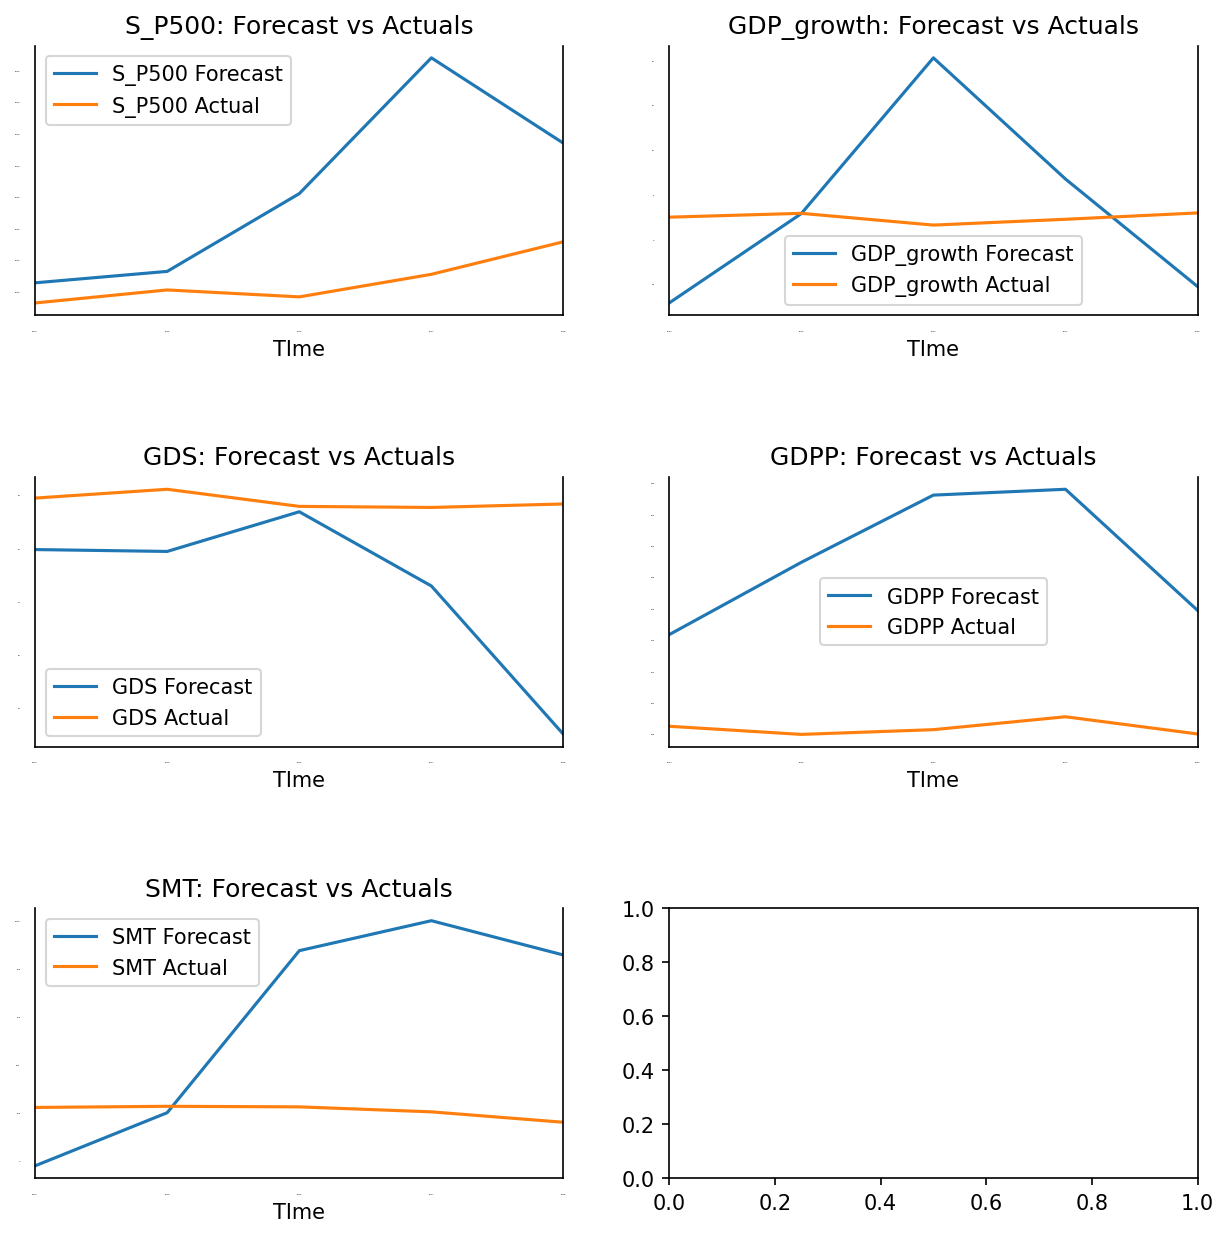

In [92]:
# differencingしないパターンでの関数を作成した
# nodiffではreverseも必要ない
def VARforecast_nodiff(data,num = 5,order = 7):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    return df_forecast
def FvsA_plot_nodiff(data,col = 2,num = 5):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    """
    reverse = VARforecast_nodiff(data, num = num)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax)
        test[col][-num:].plot(legend= True, ax=ax).autoscale(axis='x',tight=True);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} Forecast",f"{col} Actual"])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)


def forecast_data_nodiff(data,col = 2, num = 5):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = VARforecast_nodiff(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        
# no_diffの場合
def Durbin_Watson_nodiff(data,num = 5,order = 7):
    """
    ダービンワトソン検定をdifferencingなしで行う．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))

x = USA.drop("GCE",axis = 1).drop("RIR",axis = 1).drop("Turnover_Ratio",axis = 1).drop("TRADE",axis = 1).drop("Broad_money",axis = 1).drop("BCP",axis = 1)
FvsA_plot_nodiff(x)
forecast_data_nodiff(x)

In [74]:
USA.dropna()

,S_P500,GDP_growth,GCE,GDS,GDPP,SMT,TRADE,RIR,BCP,Turnover_Ratio,Broad_money
TIme,,,,,,,,,,,
1984-01-01,166.40,7.236620,15.720377,22.551567,96.796068,27.452381,17.522432,8.141075,53.519196,69.182922,73.899059
1985-01-01,171.60,4.169656,15.917109,21.560579,103.684613,33.850890,16.603906,6.563326,55.050831,63.836319,74.469224
1986-01-01,208.20,3.462652,16.114595,20.861157,110.161710,47.639635,16.897977,6.193866,56.722015,85.964113,77.170934
1987-01-01,264.50,3.459573,16.001207,20.638489,112.619055,59.255137,17.973581,5.592565,56.858347,113.634608,75.749272
1988-01-01,250.50,4.177046,15.668170,20.738735,113.690862,37.527447,19.070101,5.590367,57.335693,70.688612,75.004192
1989-01-01,285.40,3.672656,15.623797,20.976287,117.539952,41.505589,19.415128,6.690695,56.121441,69.231498,73.319708
1990-01-01,339.97,1.885960,15.900773,20.223627,114.791426,34.077601,19.815051,6.039744,52.719807,65.690326,71.223519
1991-01-01,325.49,-0.108259,16.317570,19.645951,119.177673,34.748252,19.786448,4.915352,49.086484,51.443520,70.003243
1992-01-01,416.08,3.522442,16.078687,19.544802,118.243164,38.808624,19.950595,3.884240,45.642343,55.665113,66.013361


In [ ]:
FvsA_plot(USA.drop("GCE",axis = 1).drop("TRADE",axis = 1).drop("Turnover_Ratio",axis = 1).dropna())
forecast_data(USA.drop("GCE",axis = 1).drop("TRADE",axis = 1).drop("Turnover_Ratio",axis = 1).dropna())

In [ ]:
USA.drop("RIR",axis = 1).drop("SMT",axis = 1).drop("Turnover_Ratio",axis=1).dropna()
grangers_causation_matrix(USA.dropna(),variables=USA.columns)

In [ ]:
df = differencing_data(USA.dropna())
grangers_causation_matrix(df.dropna(),variables=df.columns)

In [ ]:
cointegration_test(USA.dropna())

In [ ]:
## Durbing Watsonの関数を作る
# model = VAR(df_differenced)
# model_fitted = model.fit(4)
# out = durbin_watson(model_fitted.resid)
# for col, val in zip(df.columns, out):
#     print(adjust(col), ':', round(val, 2))

def Durbin_Watson(data,num = 5,order = 7):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
Durbin_Watson(USA.drop("GCE",axis = 1).drop("TRADE",axis = 1).drop("Turnover_Ratio",axis = 1).dropna())

In [ ]:
# no_diffの場合
def Durbin_Watson_nodiff(data,num = 5,order = 7):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
Durbin_Watson_nodiff(USA.drop("GCE",axis = 1).drop("RIR",axis = 1).drop("Turnover_Ratio",axis = 1).drop("TRADE",axis = 1).drop("Broad_money",axis = 1).drop("BCP",axis = 1))

In [ ]:
all_plot(USA.dropna(),acf= True)

Augumented Dickey-Fuller Test:
ADS test statistic       1.067086
p-value                  0.994926
# lags used              0.000000
# observations          34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -4.100322
p-value                  0.000967
# lags used              0.000000
# observations          33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
S_P500 needs 1 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -4.160494
p-value                  0.000768
# lags used              0.000000
# observatio

ADS test statistic      -4.785223
p-value                  0.000058
# lags used              0.000000
# observations          33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
SMT needs 1 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -2.016374
p-value                  0.279440
# lags used              1.000000
# observations          33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -4.168648
p-value                  0.000744
# lags used              0.000000
# observations          33.000000
Critical Val

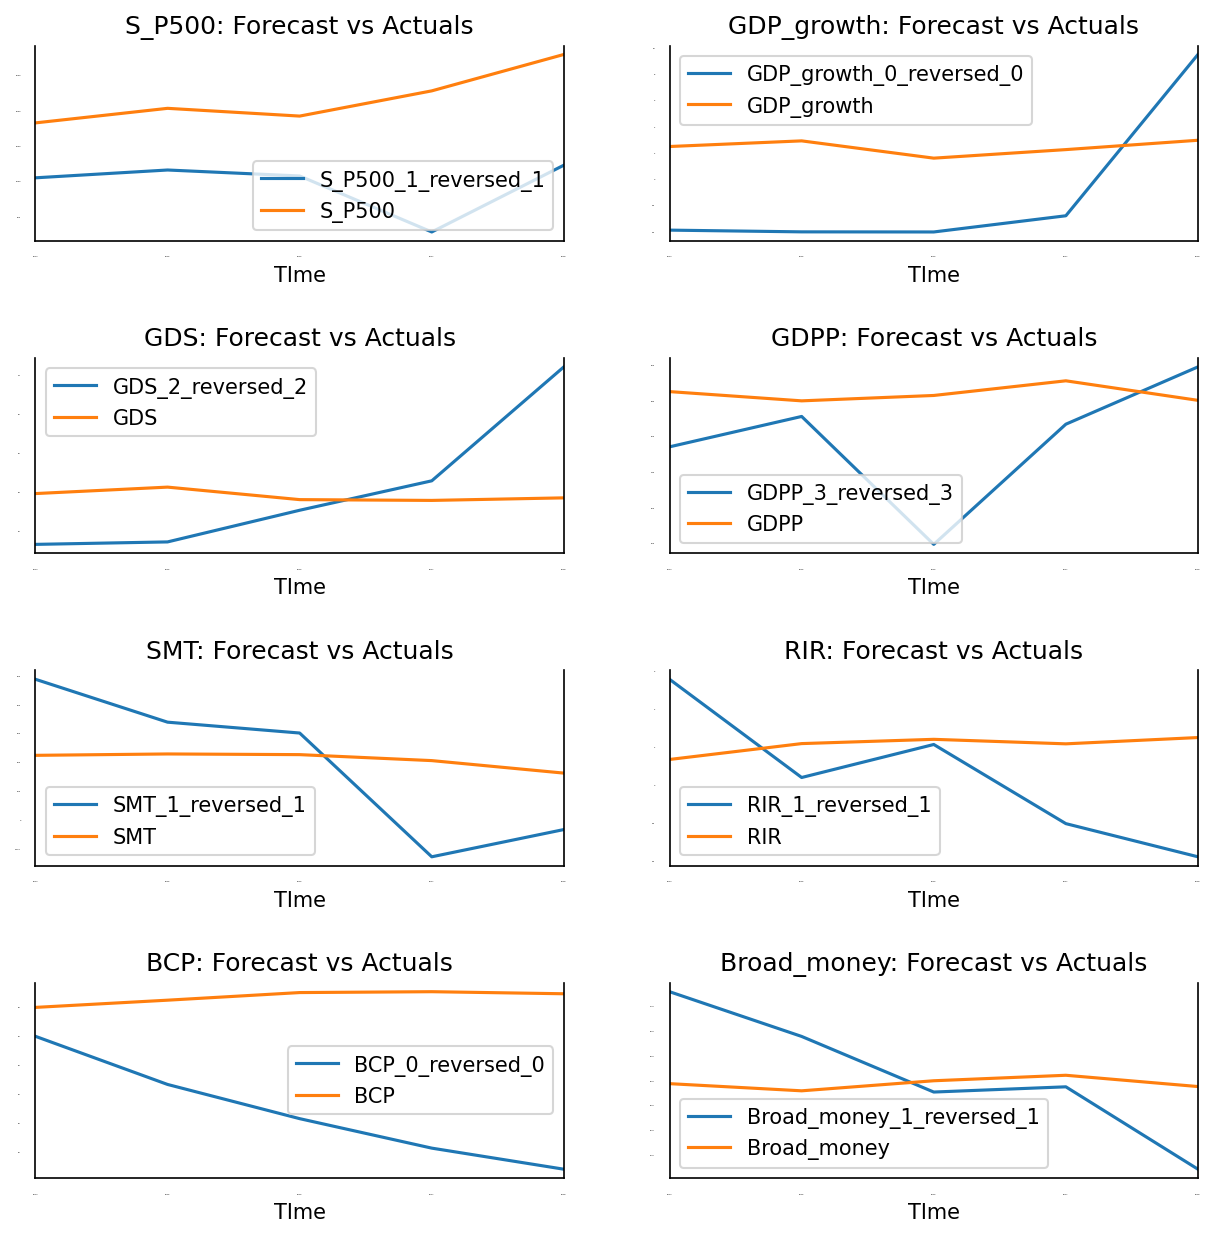

In [79]:
USA = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/FYP_USA.csv",index_col= "TIme",header = 0, parse_dates = True)
USA.index.freq = "YS"
USA.columns

In [61]:
USA.drop("RIR",axis = 1).drop("SMT",axis = 1).drop("Turnover_Ratio",axis=1).dropna()
grangers_causation_matrix(USA.dropna(),variables=USA.columns)

,S_P500_x,GDP_growth_x,GCE_x,GDS_x,GDPP_x,SMT_x,TRADE_x,RIR_x,BCP_x,Turnover_Ratio_x,Broad_money_x
S_P500_y,1.0,0.000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0
GDP_growth_y,0.0,1.000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0
GCE_y,0.0,0.000,1.0000,0.0000,0.0,0.0,0.0023,0.0001,0.0,0.0,False
GDS_y,0.0,0.000,0.0000,1.0000,0.0,0.0,0.0000,0.0011,0.0,0.0,0
GDPP_y,0.0,0.000,0.0000,0.0002,1.0,0.0,0.0001,0.0000,0.0,0.0,0.0134
SMT_y,0.0,0.000,0.0000,0.0000,0.0,1.0,0.0010,0.0000,0.0,0.0,0
TRADE_y,0.0,0.000,0.0000,0.0000,0.0,0.0,1.0000,0.0012,0.0,0.0,0
RIR_y,0.0,0.000,0.0008,0.0000,0.0,0.0,0.0000,1.0000,0.0,0.0,0
BCP_y,0.0,0.001,0.0000,0.0000,0.0,0.0,0.0000,0.0000,1.0,0.0,0
Turnover_Ratio_y,0.0,0.000,0.0000,0.0010,0.0,0.0,0.0000,0.0000,0.0,1.0,0


In [62]:
df = differencing_data(USA.dropna())
grangers_causation_matrix(df.dropna(),variables=df.columns)

Augumented Dickey-Fuller Test:
ADS test statistic       1.067086
p-value                  0.994926
# lags used              0.000000
# observations          34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -4.100322
p-value                  0.000967
# lags used              0.000000
# observations          33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
S_P500 needs 1 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -4.160494
p-value                  0.000768
# lags used              0.000000
# observatio

,S_P500_1_x,GDP_growth_0_x,GCE_0_x,GDS_2_x,GDPP_3_x,SMT_1_x,TRADE_1_x,RIR_1_x,BCP_0_x,Turnover_Ratio_1_x,Broad_money_1_x
S_P500_1_y,1.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GDP_growth_0_y,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCE_0_y,0.0,0.0,1.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GDS_2_y,0.0,0.0,0.0,1.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GDPP_3_y,0.0,0.0,0.0,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
SMT_1_y,0.0,0.0,0.0,0.0000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
TRADE_1_y,0.0,0.0,0.0,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
RIR_1_y,0.0,0.0,0.0,0.0001,0.0,0.0,0.0,1.0,0.0,0.0,0.0
BCP_0_y,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Turnover_Ratio_1_y,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [63]:
cointegration_test(USA.dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
S_P500 ::  603.06    > 263.2603  =>   True
GDP_growth ::  443.08    > 219.4051  =>   True
GCE    ::  302.53    > 179.5199  =>   True
GDS    ::  205.51    > 143.6691  =>   True
GDPP   ::  136.37    > 111.7797  =>   True
SMT    ::  88.83     > 83.9383   =>   True
TRADE  ::  56.27     > 60.0627   =>   False
RIR    ::  32.08     > 40.1749   =>   False
BCP    ::  12.95     > 24.2761   =>   False
Turnover_Ratio ::  3.67      > 12.3212   =>   False
Broad_money ::  0.26      > 4.1296    =>   False


In [81]:
## Durbing Watsonの関数を作る
# model = VAR(df_differenced)
# model_fitted = model.fit(4)
# out = durbin_watson(model_fitted.resid)
# for col, val in zip(df.columns, out):
#     print(adjust(col), ':', round(val, 2))

def Durbin_Watson(data,num = 5,order = 7):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
Durbin_Watson(USA.drop("GCE",axis = 1).drop("TRADE",axis = 1).drop("Turnover_Ratio",axis = 1).dropna())

Augumented Dickey-Fuller Test:
ADS test statistic       1.067086
p-value                  0.994926
# lags used              0.000000
# observations          34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -4.100322
p-value                  0.000967
# lags used              0.000000
# observations          33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
S_P500 needs 1 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -4.160494
p-value                  0.000768
# lags used              0.000000
# observatio

In [82]:
# no_diffの場合
def Durbin_Watson_nodiff(data,num = 5,order = 7):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
Durbin_Watson_nodiff(USA.drop("GCE",axis = 1).drop("RIR",axis = 1).drop("Turnover_Ratio",axis = 1).drop("TRADE",axis = 1).drop("Broad_money",axis = 1).drop("BCP",axis = 1))

S_P500 : 0.5
GDP_growth : 0.72
GDS    : 0.31
GDPP   : 1.3
SMT    : 1.24


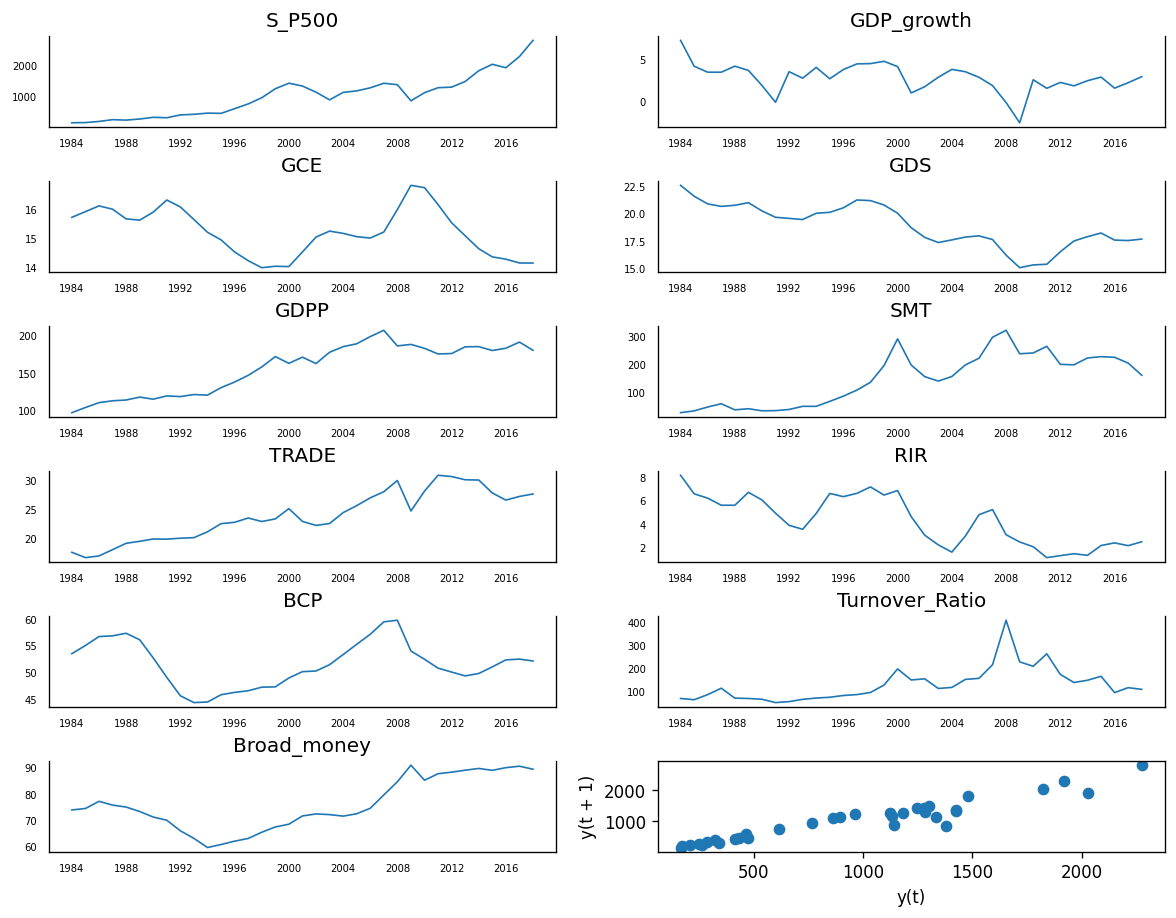

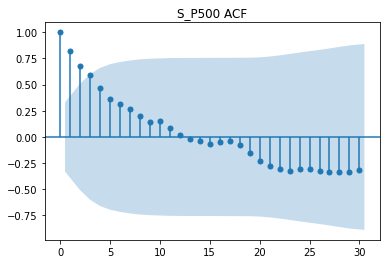

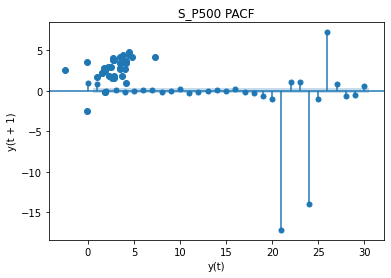

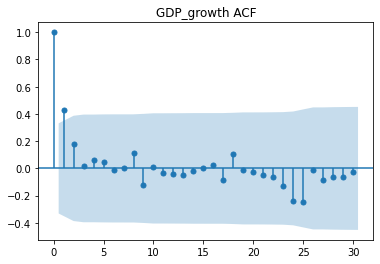

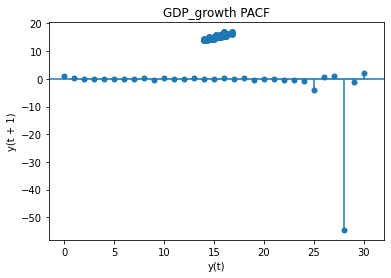

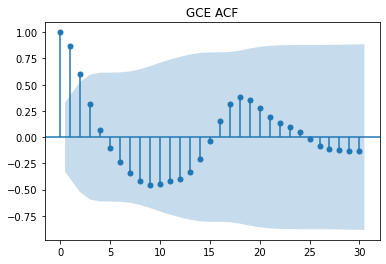

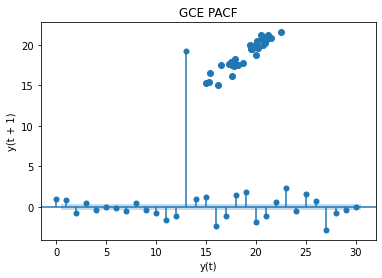

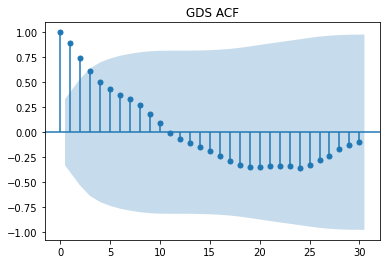

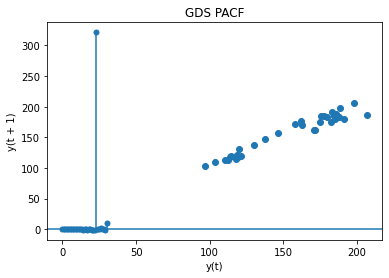

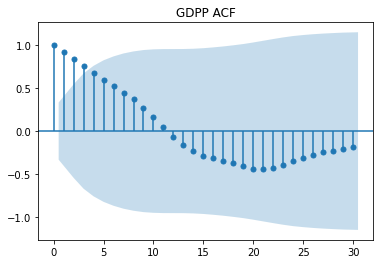

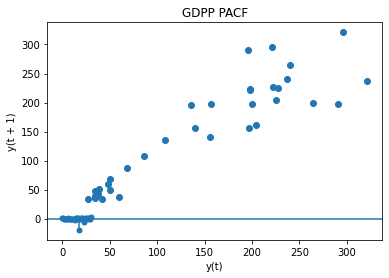

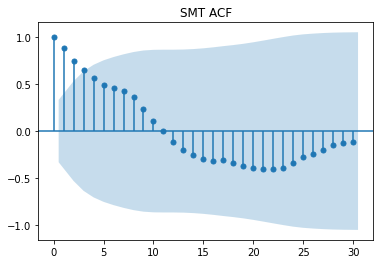

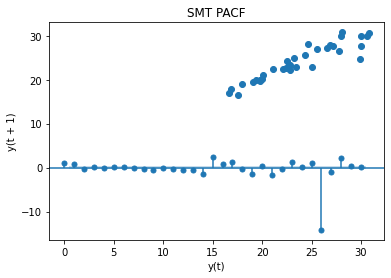

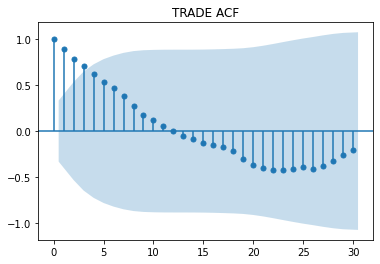

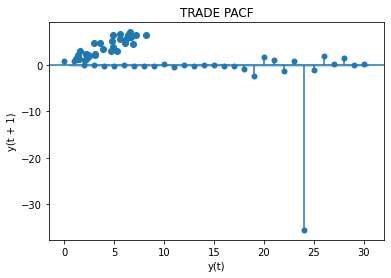

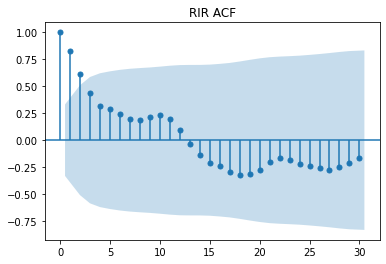

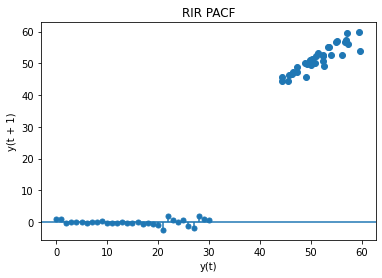

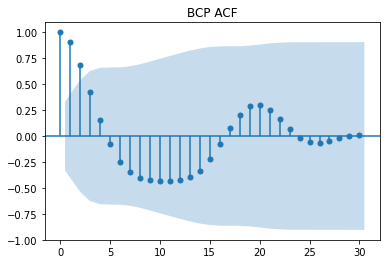

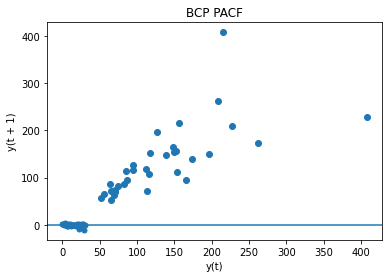

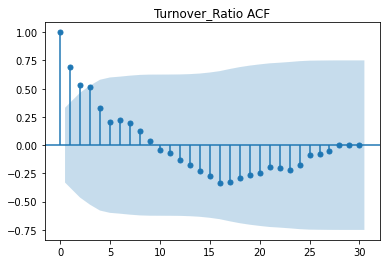

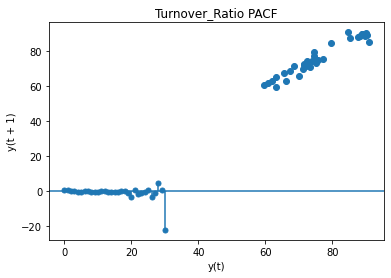

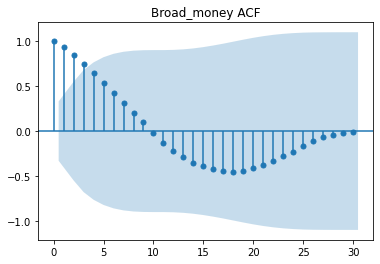

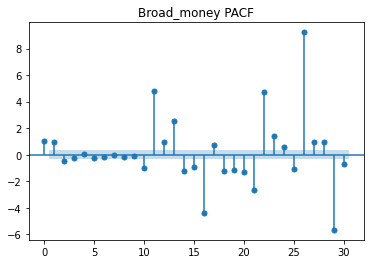

In [94]:
all_plot(USA.dropna(),acf= True)

In [4]:
USA = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/FYP_USA.csv",index_col= "TIme",header = 0, parse_dates = True)
USA.index.freq = "YS"
USA.columns

Index(['S_P500', 'GDP_growth', 'GCE', 'GDS', 'GDPP', 'SMT', 'TRADE', 'RIR',
       'BCP', 'Turnover_Ratio', 'Broad_money'],
      dtype='object')

## Procedure
1. Choose variables. 
2. Analyze each variables and test their causality by Granger causality test.
3. Modify data to obtain stationary 
4. Examine the order and fit the model to the data
5. Split data into test one, and train one. 
6. estimate the period of test data. 
7. Evaluate the model and its estimates. 
8. Retrain the model using all the data and estimate the future. 
9. Test causal inference between variables. 

1. Analyze the time series characteristics
2. Test for causation amongst the time series
3. Test for stationarity
4. Transform the series to make it stationary, if needed
5. Find optimal order (p)
6. Prepare training and test datasets
7. Train the model
8. Roll back the transformations, if any.
9. Evaluate the model using test set
10. Forecast to future

## Variables to use 
 
1. Industrial Production Index (IPI)
2. the ratio of trade to GDP (TRADE)
3. the ratio of government final consumption expenditure (GCE)
4. Bank credit to private sector (BCP)
5. the ration of private sector's domestic credit to GDP (GDPP)
6. the ratio of M3 to GDP (GDPM)
7. the ratio of domestic savings to GDP (GDS)
8. interest rates New!
9. turnover ratio
10. the ratio of stock market total value traded to GDP (SMT)


World Bank Indicator
https://databank.worldbank.org/source/world-development-indicators#

入手できた変数
Domestic credit to private sector,
GDP growth,General government final consumption expenditure (% of GDP)
GCE, Gross domestic savings (% of GDP) GCS,
Domestic credit to private sector (% of GDP)→GDPP,
Stocks traded, total value (% of GDP)→SMT,
Trade (% of GDP),
Real interest rate (%)→RIR,
Deposit interest rate (%),
Domestic credit to private sector by banks (% of GDP)→BCP,
Broad money (% of GDP) instead of GCPM
turnover ratio：stocks traded, turnover ratio of domestic shares(%)
broad moneyへの変更などが特記事項．これは論文も変える必要がある．
## Database to check


In [5]:
grangers_causation_matrix(USA.dropna(),USA.columns)

,S_P500_x,GDP_growth_x,GCE_x,GDS_x,GDPP_x,SMT_x,TRADE_x,RIR_x,BCP_x,Turnover_Ratio_x,Broad_money_x
S_P500_y,1.0,0.000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0
GDP_growth_y,0.0,1.000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0
GCE_y,0.0,0.000,1.0000,0.0000,0.0,0.0,0.0023,0.0001,0.0,0.0,False
GDS_y,0.0,0.000,0.0000,1.0000,0.0,0.0,0.0000,0.0011,0.0,0.0,0
GDPP_y,0.0,0.000,0.0000,0.0002,1.0,0.0,0.0001,0.0000,0.0,0.0,0.0134
SMT_y,0.0,0.000,0.0000,0.0000,0.0,1.0,0.0010,0.0000,0.0,0.0,0
TRADE_y,0.0,0.000,0.0000,0.0000,0.0,0.0,1.0000,0.0012,0.0,0.0,0
RIR_y,0.0,0.000,0.0008,0.0000,0.0,0.0,0.0000,1.0000,0.0,0.0,0
BCP_y,0.0,0.001,0.0000,0.0000,0.0,0.0,0.0000,0.0000,1.0,0.0,0
Turnover_Ratio_y,0.0,0.000,0.0000,0.0010,0.0,0.0,0.0000,0.0000,0.0,1.0,0


In [6]:
cointegration_test(USA.dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
S_P500 ::  603.06    > 263.2603  =>   True
GDP_growth ::  443.08    > 219.4051  =>   True
GCE    ::  302.53    > 179.5199  =>   True
GDS    ::  205.51    > 143.6691  =>   True
GDPP   ::  136.37    > 111.7797  =>   True
SMT    ::  88.83     > 83.9383   =>   True
TRADE  ::  56.27     > 60.0627   =>   False
RIR    ::  32.08     > 40.1749   =>   False
BCP    ::  12.95     > 24.2761   =>   False
Turnover_Ratio ::  3.67      > 12.3212   =>   False
Broad_money ::  0.26      > 4.1296    =>   False


In [7]:
#テストデータと訓練データに分ける
num = 5
train_USA = USA[:-num]
test_USA = USA[-num:]
test_USA

,S_P500,GDP_growth,GCE,GDS,GDPP,SMT,TRADE,RIR,BCP,Turnover_Ratio,Broad_money
TIme,,,,,,,,,,,
2015-01-01,2028.18,2.880910,14.359747,18.215694,179.716626,227.223370,27.736772,2.167481,51.048328,165.147847,88.917523
2016-01-01,1918.60,1.567215,14.280195,17.572295,182.730976,224.893926,26.514001,2.391984,52.355051,94.718850,89.932071
2017-01-01,2275.12,2.217010,14.150158,17.531695,190.948824,204.183101,27.142320,2.154929,52.503441,116.078469,90.486399
2018-01-01,2789.80,2.927323,14.147338,17.663113,180.000471,160.880542,27.564423,2.485817,52.149221,108.512636,89.347830
2019-01-01,2607.39,2.333577,NaN,NaN,192.334146,108.504230,26.388727,3.478200,52.085878,NaN,93.014309



World Bank WDI databaseからfinancial development, stock market development, real sector and economic growthなどもデータ入手先の候補
データソースは International Financial Statistics, South Africa Reserve Bank, Johannesburg Stock Exchange　ーUmar


FREDMD:id 80 : S&P 500, id 71 M2 Money stock, 
Kaggle: IPI
World Bank WDI databaseーfinancial development：BCP, GDPP, GDS 年次
World Bank WDI databaseーfinancial development, stock market development：

df =USA.iloc[:,0:5].dropna()
reverse_data(df)

df =USA.iloc[:,0:5].dropna()
reverse_data(df)

In [ ]:
df =USA.iloc[:,0:5].dropna()
reverse_data(df)

In [8]:
df = USA.drop("RIR",axis = 1).drop("Turnover_Ratio",axis = 1)
#df_forecast = VARforecast(df)
idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
new_data = pd.DataFrame(index = idx)
diff_data = pd.DataFrame(index = idx)
columns = df_forecast.columns
for column in columns:
    diff_time = int(column[-1])
    if diff_time == 0:
        new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
    if diff_time == 1:
        new_data[f"{column}_reversed_{diff_time}"] = df[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
    if diff_time == 2:
        diff_data[f"{column}_reversed_1"] = df[column[:-2]].iloc[-num-1] - df[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
        new_data[f"{column}_reversed_{diff_time}"] = df[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
    if diff_time == 3:
        diff_data[f"{column}_reversed_1"] = df[column[:-2]].iloc[-num-1] - 2*df[column[:-2]].iloc[-num-2] + df[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
        diff_data[f"{column}_reversed_2"] = df[column[:-2]].iloc[-num-1] - df[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
        new_data[f"{column}_reversed_{diff_time}"] = df[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
new_data["S_P500_3_reversed_3"].plot()
df["S_P500"]["2014-01-01":].plot();

NameError: name 'df_forecast' is not defined

In [9]:
# df = USA.drop("RIR",axis = 1).drop("Turnover_Ratio",axis = 1)
# a = VARforecast(df

In [10]:
df["S_P500"]["2014-01-01":]

TIme
2014-01-01    1822.36
2015-01-01    2028.18
2016-01-01    1918.60
2017-01-01    2275.12
2018-01-01    2789.80
2019-01-01    2607.39
Freq: AS-JAN, Name: S_P500, dtype: float64

In [11]:
forecast[0]
idx = pd.date_range('2014-01-01', periods=5, freq='YS')
df_forecast = pd.DataFrame(forecast, index=idx, columns=test.columns.drop("Turnover_Ratio_1").drop("RIR_1"))
df_forecast["GCE_1"].plot(legend = True)
test["GCE_1"].plot()

NameError: name 'forecast' is not defined

In [12]:
df["S_P500"]["2014-01-01":]

TIme
2014-01-01    1822.36
2015-01-01    2028.18
2016-01-01    1918.60
2017-01-01    2275.12
2018-01-01    2789.80
2019-01-01    2607.39
Freq: AS-JAN, Name: S_P500, dtype: float64

In [13]:
forecast[0]
idx = pd.date_range('2014-01-01', periods=5, freq='YS')
df_forecast = pd.DataFrame(forecast, index=idx, columns=test.columns.drop("Turnover_Ratio_1").drop("RIR_1"))
df_forecast["GCE_1"].plot(legend = True)
test["GCE_1"].plot()

NameError: name 'forecast' is not defined

In [14]:
#一定の期間の予測を行う関数を作成する
df_forecast = results.forecast(12)

NameError: name 'results' is not defined

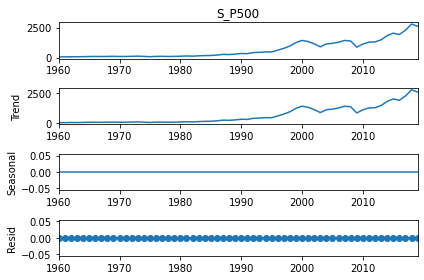

In [15]:
plot_series(USA["S_P500"])

In [16]:
USA["S_P500"]

TIme
1960-01-01      58.03
1961-01-01      59.72
1962-01-01      69.07
1963-01-01      65.06
1964-01-01      76.45
1965-01-01      86.12
1966-01-01      93.32
1967-01-01      84.45
1968-01-01      95.04
1969-01-01     102.00
1970-01-01      90.31
1971-01-01      93.49
1972-01-01     103.30
1973-01-01     118.40
1974-01-01      96.11
1975-01-01      72.56
1976-01-01      96.86
1977-01-01     103.80
1978-01-01      90.25
1979-01-01      99.71
1980-01-01     110.90
1981-01-01     133.00
1982-01-01     117.30
1983-01-01     144.30
1984-01-01     166.40
1985-01-01     171.60
1986-01-01     208.20
1987-01-01     264.50
1988-01-01     250.50
1989-01-01     285.40
1990-01-01     339.97
1991-01-01     325.49
1992-01-01     416.08
1993-01-01     435.23
1994-01-01     472.99
1995-01-01     465.25
1996-01-01     614.42
1997-01-01     766.22
1998-01-01     963.36
1999-01-01    1248.77
2000-01-01    1425.59
2001-01-01    1335.63
2002-01-01    1140.21
2003-01-01     895.84
2004-01-01    1132.52
2005-

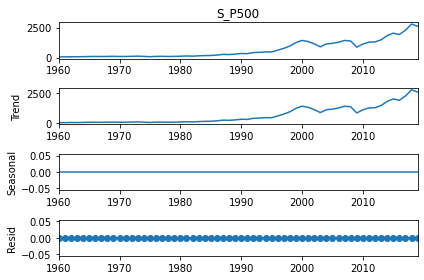

In [17]:
plot_series(USA["S_P500"])

In [18]:
USA["S_P500"]

TIme
1960-01-01      58.03
1961-01-01      59.72
1962-01-01      69.07
1963-01-01      65.06
1964-01-01      76.45
1965-01-01      86.12
1966-01-01      93.32
1967-01-01      84.45
1968-01-01      95.04
1969-01-01     102.00
1970-01-01      90.31
1971-01-01      93.49
1972-01-01     103.30
1973-01-01     118.40
1974-01-01      96.11
1975-01-01      72.56
1976-01-01      96.86
1977-01-01     103.80
1978-01-01      90.25
1979-01-01      99.71
1980-01-01     110.90
1981-01-01     133.00
1982-01-01     117.30
1983-01-01     144.30
1984-01-01     166.40
1985-01-01     171.60
1986-01-01     208.20
1987-01-01     264.50
1988-01-01     250.50
1989-01-01     285.40
1990-01-01     339.97
1991-01-01     325.49
1992-01-01     416.08
1993-01-01     435.23
1994-01-01     472.99
1995-01-01     465.25
1996-01-01     614.42
1997-01-01     766.22
1998-01-01     963.36
1999-01-01    1248.77
2000-01-01    1425.59
2001-01-01    1335.63
2002-01-01    1140.21
2003-01-01     895.84
2004-01-01    1132.52
2005-